# Network 3 - without split

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import time
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn.parameter import Parameter

from sklearn.preprocessing import StandardScaler

path_to_utils = os.path.join('.', 'python_functions')
path_to_utils = os.path.abspath(path_to_utils)
if path_to_utils not in sys.path:
    sys.path.insert(0, path_to_utils)

import mf_utils as util
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import mean_absolute_error

### Basic parameters

In [6]:
#%% Basic parameters

num_atoms = 782
num_fasc = 2
num_params = 6 #nombre de paramètres à estimer: ['nu1', 'r1 ', 'f1 ', 'nu2', 'r2 ', 'f2 ']


params3 = {
    #Training parameters
    "num_samples": 300000,
     "batch_size": 500,  
     "num_epochs": 30,
     
     #NW3
     "num_h1": 250,
     "num_h2": 400,
     "num_h3": 500,
     "num_h4": 100,
     "num_h5": 50,
     
     #other
     "learning_rate": 0.001 
     #"learning_rate": hp.uniform("learningrate", 0.001, 0.005)
}

num_samples = params3["num_samples"]
num_div = int(num_samples/4)

### Loading the data

In [8]:
from getDataW import gen_batch_data

print("OK")

w_store1, target_params1 = gen_batch_data(0, num_div*2, 'train')
print(w_store1.shape)
w_store2, target_params2 = gen_batch_data(0, num_div*2, 'validation')

print(w_store2.shape)

torch.Size([150000, 1564]) torch.Size([150000, 1564])


In [9]:
print('----------------------- Data --------------------------')

# divide data in train, test and validation
x_train = w_store1[:, :]
x_test = w_store2[0:num_div , :]
x_valid = w_store2[num_div : 2*num_div, :]

print('x_train size', x_train.shape)
print('x_test size', x_test.shape)
print('x_valid size', x_valid.shape)

# modification for the NN
x_train = x_train.float()
x_test = x_test.float()
x_valid = x_valid.float()

print("--- Taking microstructural properties of fascicles ---")

#Scaling: scaler: (num_samples, num_features)

scaler_train = StandardScaler()
target_params1 = scaler_train.fit_transform(target_params1)
target_params1 = torch.from_numpy(target_params1)

scaler_valid = StandardScaler()
target_params2 = scaler_valid.fit_transform(target_params2)
target_params2 = torch.from_numpy(target_params2)

## Dividing in train test and valid

target_train = target_params1[:, :]
target_test = target_params2[0:num_div, :]
target_valid = target_params2[num_div:2*num_div, :]

target_train = target_train.float()
target_test = target_test.float()
target_valid = target_valid.float()

print('target_train size', target_train.shape)
print('target_test size', target_test.shape)
print('target_valid size', target_valid.shape)

----------------------- Data --------------------------
x_train size torch.Size([150000, 1564])
x_test size torch.Size([75000, 1564])
x_valid size torch.Size([75000, 1564])
--- Taking microstructural properties of fascicles ---
target_train size torch.Size([150000, 6])
target_test size torch.Size([75000, 6])
target_valid size torch.Size([75000, 6])


### Defining the Network

In [10]:
class Net3(nn.Module):

    def __init__(self, num_in, num_h1, num_h2, num_h3, num_h4, num_h5,  num_out, drop_prob):
        super(Net3, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h1, num_in)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_h1), 0))

        # hidden layer
        self.W_2 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h2, num_h1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_h2), 0))
        
        self.W_3 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h3, num_h2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_h3), 0))
        
        self.W_4 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h4, num_h3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_h4), 0))
        
        self.W_5 = Parameter(init.kaiming_uniform_(torch.Tensor(num_h5, num_h4)))
        self.b_5 = Parameter(init.constant_(torch.Tensor(num_h5), 0))
        
        self.W_6 = Parameter(init.kaiming_uniform_(torch.Tensor(num_out, num_h5)))
        self.b_6 = Parameter(init.constant_(torch.Tensor(num_out), 0))
        
        self.activation = torch.nn.ReLU()
        
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):

        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)

        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_4, self.b_4)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_5, self.b_5)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_6, self.b_6)

        return x

### Defining the training loop

In [11]:
def train_network3(params3: dict):
    
    num_in = 2*num_atoms
    num_out = 6
    num_h1 = params3["num_h1"]
    num_h2 = params3["num_h2"]
    num_h3 = params3["num_h3"] 
    num_h4 = params3["num_h4"]
    num_h5 = params3["num_h5"]
    
    net3 = Net3(num_in, num_h1, num_h2, num_h3, num_h4, num_h5, num_out, drop_prob=0.3)
    
    print(net3)
    
    # Optimizer and Criterion    
    optimizer = optim.Adam(net3.parameters(), lr=params3["learning_rate"], weight_decay=0.0000001)
    lossf = nn.MSELoss()
    
    print('----------------------- Training --------------------------')
    
    # setting hyperparameters and gettings epoch sizes
    batch_size = params3["batch_size"]  
    num_epochs = params3["num_epochs"] 
    num_samples_train = int(num_samples/2)
    num_batches_train = num_samples_train // batch_size 
    num_samples_valid = int(num_samples/4)
    num_batches_valid = num_samples_valid // batch_size
    
    print(num_batches_train, num_batches_valid)
    
    # setting up lists for handling loss/accuracy
    train_acc = np.zeros((num_epochs, num_params))
    valid_acc = np.zeros((num_epochs, num_params))
    
    meanTrainError, meanValError  = [], []

    cur_loss = 0
    losses = []
    
    # lambda function
    get_slice = lambda i, size: range(i * size, (i + 1) * size)
    
    for epoch in range(num_epochs):
        # Forward -> Backprob -> Update params
        ## Train
        cur_loss = 0
        net3.train()
        
        for i in range(num_batches_train):
            
            optimizer.zero_grad()
            slce = get_slice(i, batch_size)
    
            output = net3(x_train[slce, :])
            
            # compute gradients given loss
            target_batch = target_train[slce]
            batch_loss = lossf(output, target_batch)
            batch_loss.backward()
            optimizer.step()
            
            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)
    
        net3.eval()
        
        ### Evaluate training
        train_preds = [[], [], [], [], [], []]
        train_targs = [[], [], [], [], [], []]
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            preds = net3(x_train[slce, :])
            
            for j in range(num_params):
                train_targs[j] += list(target_train[slce, j].numpy())
                train_preds[j] += list(preds.data[:,j].numpy())
            
        ### Evaluate validation
        val_preds = [[], [], [], [], [], []]
        val_targs = [[], [], [], [], [], []]
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            preds = net3(x_valid[slce, :])
            
            for j in range(num_params):
                val_targs[j] += list(target_valid[slce, j].numpy())
                val_preds[j] += list(preds.data[:,j].numpy())
                
        # Save evaluation and training
        train_acc_cur = np.zeros(num_params)
        valid_acc_cur = np.zeros(num_params)
        for j in range(num_params):
            train_acc_cur[j] = mean_absolute_error(train_targs[j], train_preds[j])
            valid_acc_cur[j] = mean_absolute_error(val_targs[j], val_preds[j])
            train_acc[epoch, j] = train_acc_cur[j]
            valid_acc[epoch, j] = valid_acc_cur[j]

        meanTrainError.append(np.mean(train_acc[epoch,:]))
        meanValError.append(np.mean(valid_acc[epoch, :]))
        
        if epoch % 10 == 0:
            print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f, " %(
                    epoch+1, losses[-1], meanTrainError[-1], meanValError[-1]))
        
    to_min = sum(valid_acc_cur)
      
    return {"loss": to_min, 
            "model": net3, 
            "params": params3, 
            "status": STATUS_OK,
            "train_acc": train_acc,
            "valid_acc": valid_acc,
            "meanTrainError": meanTrainError,
            "meanValError": meanValError
            }

### Training the network

In [12]:
tic = time.time()
trial = train_network3(params3)  
toc = time.time()

print("training time:", toc-tic, "[sec]")

Net3(
  (activation): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
----------------------- Training --------------------------
300 150
Epoch  1 : Train Loss 0.646696 , Train acc 0.839085, Valid acc 0.839197, 
Epoch 11 : Train Loss 0.211311 , Train acc 0.390279, Valid acc 0.388621, 
Epoch 21 : Train Loss 0.181315 , Train acc 0.345058, Valid acc 0.342924, 
training time: 705.1429150104523 [sec]


### Graphs for training (learning curves)

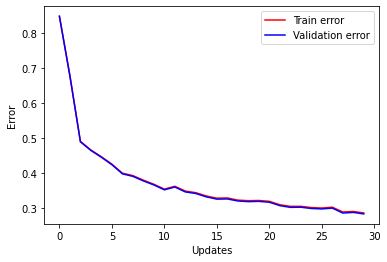

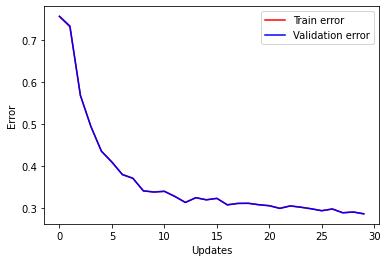

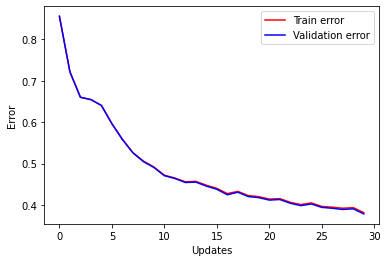

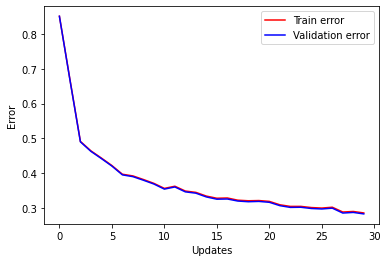

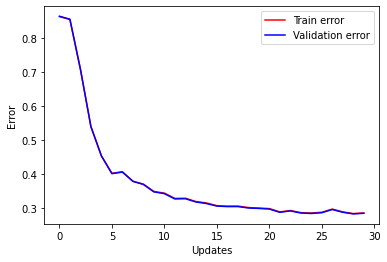

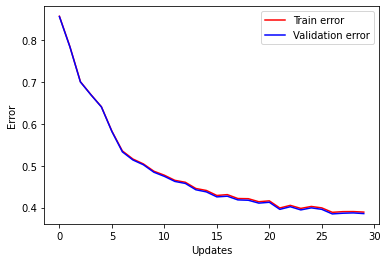

[0.8390854299068451, 0.7404910922050476, 0.6033100634813309, 0.5480494052171707, 0.510037918885549, 0.47290758788585663, 0.44606395562489826, 0.429336816072464, 0.4136367440223694, 0.4004750996828079, 0.3902790645758311, 0.3848981410264969, 0.37569084763526917, 0.372209757566452, 0.3649783134460449, 0.3588542838891347, 0.35455232858657837, 0.3523462663094203, 0.34934601187705994, 0.3471055825551351, 0.34505772093931836, 0.33646951615810394, 0.3361039360364278, 0.3324602047602336, 0.331929475069046, 0.32907599210739136, 0.3300601541996002, 0.3224320908387502, 0.3226829518874486, 0.31855865319569904]


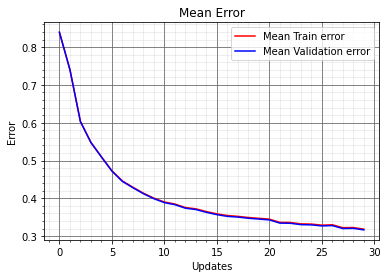

In [13]:
train_acc = trial['train_acc']
valid_acc = trial['valid_acc']
epoch = np.arange(params3['num_epochs'])

mean_train_error = trial['meanTrainError']

for j in range(num_params):    
    plt.figure()
    plt.plot(epoch, train_acc[:, j], 'r', epoch, valid_acc[:, j], 'b')
    plt.legend(['Train error','Validation error'])
    plt.xlabel('Updates'), plt.ylabel('Error')
    plt.show()
    
meanTrainError = trial['meanTrainError']
meanValError = trial['meanValError']

# Mean Error
print(trial['meanTrainError'])
plt.figure()
plt.plot(epoch, meanTrainError, 'r', epoch, meanValError, 'b')
plt.title('Mean Error')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend(['Mean Train error','Mean Validation error'])
plt.xlabel('Updates'), plt.ylabel('Error')
plt.show()

### Testing the network on unseen data

----------------------- Prediction --------------------------
torch.Size([75000, 1564])
[8.0803007e-01 3.4000000e-06 3.0000001e-01 1.9196993e-01 4.8000002e-06
 6.0000002e-01]


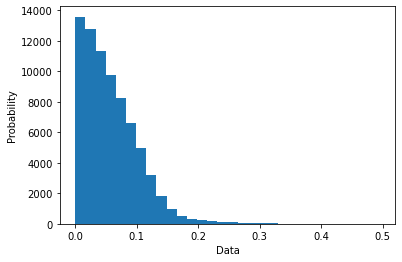

In [14]:
print('----------------------- Prediction --------------------------')

net3 = trial['model']

print(x_test.shape)
output = net3(x_test)
output = output.detach().numpy()

output = scaler_valid.inverse_transform(output)
target_test = scaler_valid.inverse_transform(target_test)

print(target_test[0, :])

error = output - target_test

abserror = abs(error)

##plt.figure()
##plt.plot(range(len(target_test)), error)
##plt.xlabel('samples')
##plt.ylabel('Abs error')
##plt.show()

plt.figure()
plt.hist(abserror[:,0], density=False, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

### Confidence intervals

In [15]:
conf_int = np.zeros(num_params)

for j in range(num_params):
    #plt.plot(error[:,j])
    #plt.show()
    data = error[:,j]
    
    mean = np.mean(data)
    sigma = np.std(data)
    
    confint = stats.norm.interval(0.95, loc=mean, 
        scale=sigma)
    
    print(confint)

(-0.155014020185884, 0.12889190463345862)
(-1.572325349976341e-06, 1.5738691070984764e-06)
(-0.1987924150018804, 0.18170433703948188)
(-0.12890080568534368, 0.15502623488348954)
(-1.6325013964458792e-06, 1.5242499264357337e-06)
(-0.20939681654137765, 0.17668602963251268)
